In [385]:
import pandas as pd
import os
import torch
import numpy as np
import scipy.stats as stats
from pprint import pprint

config = {
    "runs_folder": "final_data_2",
    "results_folder": "/storage/scratch/groshchupkin/Tom_dataset/results/",
    "data_path": "/storage/scratch/groshchupkin/Tom_dataset/"
}
results_file = "test_dataset_results.json"

runs_folder = os.listdir(config["results_folder"] + config["runs_folder"])
run_paths = {
    "bionet": dict(),
    "logreg": dict(),
}

for folder in runs_folder:
    if "bionet" in folder:
        seed = folder.split("_")[-1]
        run_paths["bionet"][f"seed_{seed}"] = config["results_folder"] + config["runs_folder"] + f"/{folder}/"
    else:
        seed = folder.split("_")[-1]
        run_paths["logreg"][f"seed_{seed}"] = config["results_folder"] + config["runs_folder"] + f"/{folder}/"

In [386]:
import json

results_data = {
    "mcc": {
        "bionet": [],
        "logreg": [],
    },
    "f1_score": {
        "bionet": [],
        "logreg": [],
    },
    "auc_pr": {
        "bionet": [],
        "logreg": [],
    },
    "roc_auc": {
        "bionet": [],
        "logreg": [],
    },
    "confusion_matrix": {
        "bionet": {
            "TP": [],
            "TN": [],
            "FP": [],
            "FN": [],
        },
        "logreg": {
            "TP": [],
            "TN": [],
            "FP": [],
            "FN": [],
        },
    }
}

for model_type in run_paths:
    for seed, path in run_paths[model_type].items():
        with open(path + results_file, 'r') as file:
            seed_results = json.load(file) 
        for metric_type in results_data:
            if metric_type == "confusion_matrix":
                results_data["confusion_matrix"][model_type]["TP"].append(seed_results['confusion_matrix'][1][1])
                results_data["confusion_matrix"][model_type]["TN"].append(seed_results['confusion_matrix'][0][0])
                results_data["confusion_matrix"][model_type]["FP"].append(seed_results['confusion_matrix'][0][1])
                results_data["confusion_matrix"][model_type]["FN"].append(seed_results['confusion_matrix'][1][0])
                break
            else:
                results_data[metric_type][model_type].append(seed_results[metric_type])
        true_class = round(row['true_class'])
        predicted_class = round(row['predicted_class'])
        is_misclass = true_class != predicted_class

In [344]:
# Example lists of scores
results_statistics = {
    "mcc": {
        "bionet": dict(),
        "logreg": dict(),
    },
    "f1_score": {
        "bionet": dict(),
        "logreg": dict(),
    },
    "auc_pr": {
        "bionet": dict(),
        "logreg": dict(),
    },
    "roc_auc": {
        "bionet": dict(),
        "logreg": dict(),
    },
    "confusion_matrix": {
        "bionet": {
            "TP": dict(),
            "TN": dict(),
            "FP": dict(),
            "FN": dict(),
        },
        "logreg": {
            "TP": dict(),
            "TN": dict(),
            "FP": dict(),
            "FN": dict(),
        },
    }
}
combined_statistics = True
for metric_type in results_data:
    if metric_type == "confusion_matrix":
        for model_type in ["bionet", "logreg"]:
            for XX in results_data[metric_type][model_type]:
                res_data = results_data[metric_type][model_type][XX]
                results_statistics[metric_type][model_type][XX]["mean"] = np.mean(res_data)
                results_statistics[metric_type][model_type][XX]["std"] = np.std(res_data, ddof=1)
    else:
        for model_type in ["bionet", "logreg"]:
            res_data = results_data[metric_type][model_type]
            results_statistics[metric_type][model_type]["mean"] = np.mean(res_data)
            results_statistics[metric_type][model_type]["std"] = np.std(res_data, ddof=1)  # ddof=1 to get the sample standard deviation
        if combined_statistics:
            t_statistic, p_value = stats.ttest_rel(results_data[metric_type]["bionet"], results_data[metric_type]["logreg"])
            results_statistics[metric_type]["t_statistic"] = t_statistic
            results_statistics[metric_type]["p_value"] = p_value
            results_statistics[metric_type]["statistically_significant"] = p_value < 0.05

pprint(results_statistics)

{'auc_pr': {'bionet': {'mean': 0.1894683077385705, 'std': 0.059777551439663554},
            'logreg': {'mean': 0.16035170584397818, 'std': 0.04441113948444804},
            'p_value': 0.00023152557781976345,
            'statistically_significant': True,
            't_statistic': 3.821781542846704},
 'confusion_matrix': {'bionet': {'FN': {'mean': 7.36,
                                        'std': 2.2406708952021623},
                                 'FP': {'mean': 54.91,
                                        'std': 10.758219784392441},
                                 'TN': {'mean': 142.09,
                                        'std': 10.758219784392441},
                                 'TP': {'mean': 9.64,
                                        'std': 2.2406708952021623}},
                      'logreg': {'FN': {'mean': 11.91,
                                        'std': 1.775791188015737},
                                 'FP': {'mean': 22.78,
                            

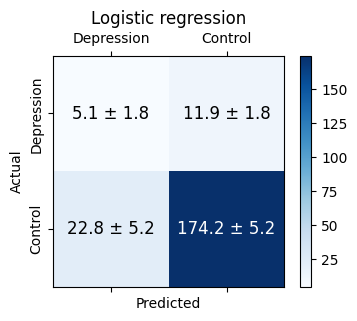

In [367]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

model = 'logreg'
# Sample values for confusion matrix
cm = results_statistics['confusion_matrix']
TP_mean, TP_std = cm[model]["TP"]['mean'], cm[model]["TP"]['std']
FP_mean, FP_std = cm[model]["FP"]['mean'], cm[model]["FP"]['std']
FN_mean, FN_std = cm[model]["FN"]['mean'], cm[model]["FN"]['std']
TN_mean, TN_std = cm[model]["TN"]['mean'], cm[model]["TN"]['std']

# Numerical values for color intensity
values = np.array([[TP_mean, FN_mean],
                   [FP_mean, TN_mean]])

# Creating the confusion matrix with mean ± std format
confusion_matrix = [
    [f"{TP_mean:.1f} ± {TP_std:.1f}", f"{FN_mean:.1f} ± {FN_std:.1f}"],
    [  f"{FP_mean:.1f} ± {FP_std:.1f}", f"{TN_mean:.1f} ± {TN_std:.1f}"]
]
norm = Normalize(vmin=0, vmax=250)
# Adjust the size of the plot by modifying the figsize parameter
fig, ax = plt.subplots(figsize=(4, 3))  # You can change these values as needed
cax = ax.matshow(values, cmap='Blues')

# Annotating the cells with mean ± std values
for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:
            ax.text(j, i, confusion_matrix[i][j], ha='center', va='center', color='white', fontsize=12)
        else:
            ax.text(j, i, confusion_matrix[i][j], ha='center', va='center', color='black', fontsize=12)

# Adding titles and labels
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Depression', 'Control'])
ax.set_yticklabels(['Depression', 'Control'], rotation=90, va='center')

plt.title('Logistic regression')
plt.colorbar(cax)
plt.show()

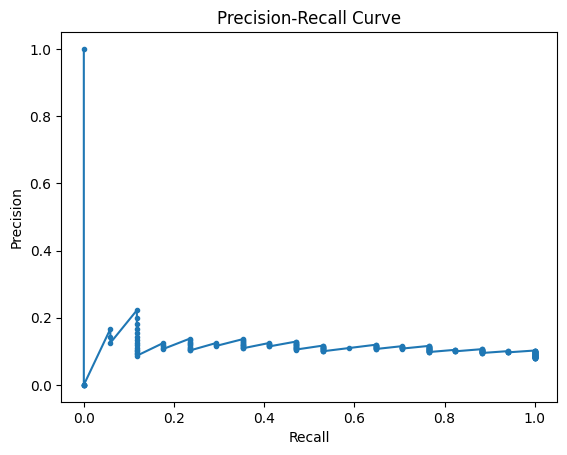

In [372]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

label_str = 'test_labels.npy'
pred_str = 'test_preds.npy'
for model_type in ['bionet', 'logreg']:
    for seed, path in run_paths[model_type].items():
        seed_labels = np.load(path + label_str) 
        seed_pred = np.load(path + pred_str) 

    

precision, recall, _ = precision_recall_curve(seed_labels, seed_pred)
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

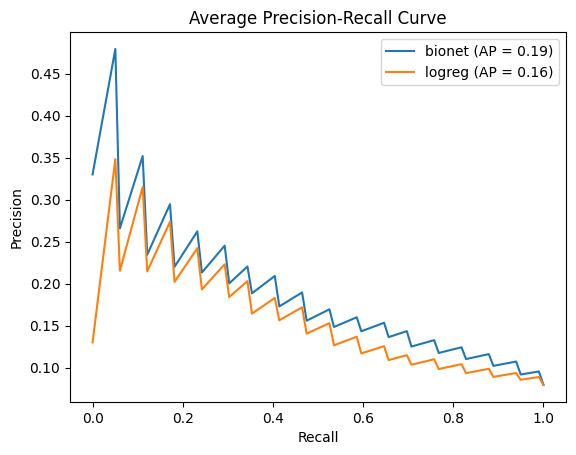

In [377]:
from sklearn.metrics import precision_recall_curve, auc
label_str = 'test_labels.npy'
pred_str = 'test_preds.npy'

precision_dict = {}
recall_dict = {}
average_precision_dict = {}

for model_type in ['bionet', 'logreg']:
    all_precisions = []
    all_recalls = []
    all_aps = []

    for seed, path in run_paths[model_type].items():
        seed_labels = np.load(path + label_str) 
        seed_pred = np.load(path + pred_str)
        
        precision, recall, _ = precision_recall_curve(seed_labels, seed_pred)
        average_precision = auc(recall, precision)

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_aps.append(average_precision)

    # Compute the average precision-recall curve
    average_precision_dict[model_type] = np.mean(all_aps)
    mean_recall = np.linspace(0, 1, 100)
    mean_precision = np.zeros_like(mean_recall)

    for precision, recall in zip(all_precisions, all_recalls):
        mean_precision += np.interp(mean_recall, recall[::-1], precision[::-1])

    mean_precision /= len(all_precisions)
    precision_dict[model_type] = mean_precision
    recall_dict[model_type] = mean_recall

# Plotting
plt.figure()

for model_type in ['bionet', 'logreg']:
    plt.plot(recall_dict[model_type], precision_dict[model_type],
             label=f'{model_type} (AP = {average_precision_dict[model_type]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Average Precision-Recall Curve')
plt.legend()
plt.show()

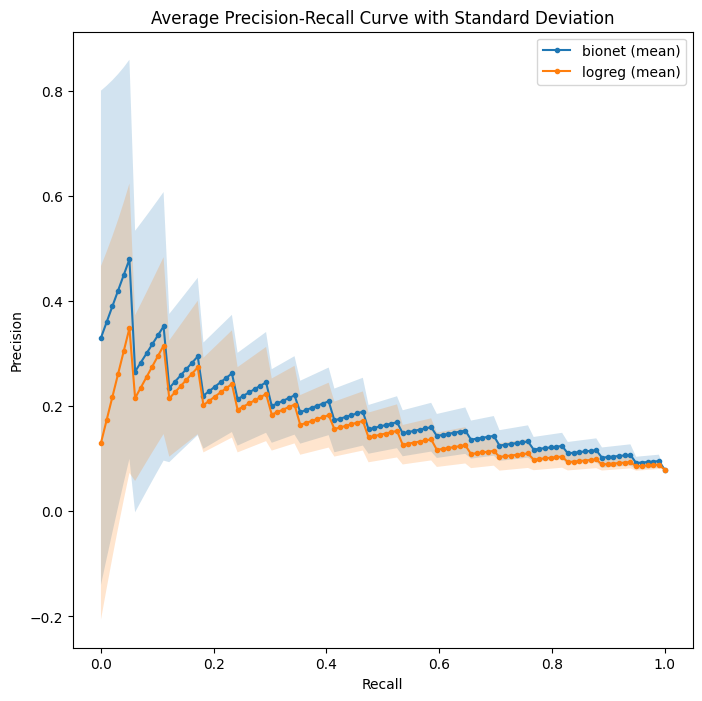

In [383]:
plt.figure(figsize=(8, 8))

mean_recall = np.linspace(0, 1, 100)

for model_type in ['bionet', 'logreg']:
    all_precisions = []
    all_recalls = []

    for seed, path in run_paths[model_type].items():
        seed_labels = np.load(path + label_str) 
        seed_pred = np.load(path + pred_str)
        
        precision, recall, _ = precision_recall_curve(seed_labels, seed_pred)
        # Interpolate precision values to a common recall grid
        interpolated_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
        all_precisions.append(interpolated_precision)
        all_recalls.append(recall)
        
    # Calculate mean and standard deviation of precision at each recall level
    mean_precision = np.mean(all_precisions, axis=0)
    std_precision = np.std(all_precisions, axis=0)
    
    plt.plot(mean_recall, mean_precision, marker='.', label=f'{model_type} (mean)')
    plt.fill_between(mean_recall, mean_precision - std_precision, mean_precision + std_precision, alpha=0.2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Average Precision-Recall Curve with Standard Deviation')
plt.legend()
plt.show()

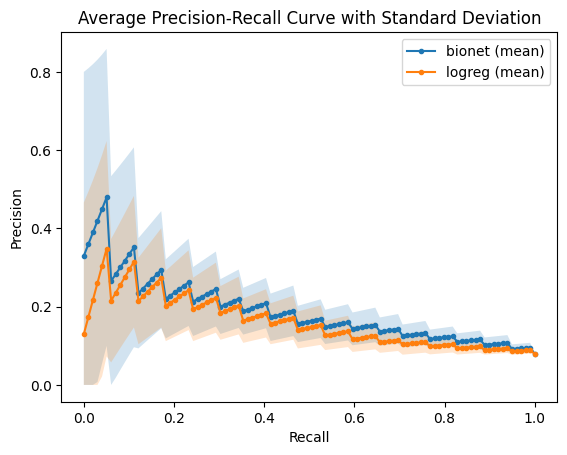

In [389]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

label_str = 'test_labels.npy'
pred_str = 'test_preds.npy'

plt.figure()

mean_recall = np.linspace(0, 1, 100)

for model_type in ['bionet', 'logreg']:
    all_precisions = []
    all_recalls = []

    for seed, path in run_paths[model_type].items():
        seed_labels = np.load(path + label_str) 
        seed_pred = np.load(path + pred_str)
        
        precision, recall, _ = precision_recall_curve(seed_labels, seed_pred)
        # Interpolate precision values to a common recall grid
        interpolated_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
        all_precisions.append(interpolated_precision)
        all_recalls.append(recall)
    # Calculate mean and standard deviation of precision at each recall level
    mean_precision = np.mean(all_precisions, axis=0)
    std_precision = np.std(all_precisions, axis=0)
    
    # Clip values to be between 0 and 1
    mean_precision_upper = np.clip(mean_precision + std_precision, 0, 1)
    mean_precision_lower = np.clip(mean_precision - std_precision, 0, 1)
    
    plt.plot(mean_recall, mean_precision, marker='.', label=f'{model_type} (mean)')
    plt.fill_between(mean_recall, mean_precision_lower, mean_precision_upper, alpha=0.2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Average Precision-Recall Curve with Standard Deviation')
plt.legend()
plt.show()


In [202]:
def get_model_importance(model_weights, model_type='bionet'):
    if model_type == 'bionet':
        weight_importance = (model_weights['hidden_layer1.weights'] @ model_weights['hidden_layer2.weights']) @ model_weights['hidden_to_output.weight'].T
    else: # logistic regression
        weight_importance = model_weights['linear.weight'].T
    
    importance = torch.abs(weight_importance) / torch.sum(torch.abs(weight_importance))

    return importance.detach().numpy().flatten()

In [306]:
all_annotations = pd.read_csv(config["data_path"] + "all_annotations.csv")
seed_weights = dict()
seed_keys = []

for seed, path in run_paths["bionet"].items():
    seed_weights[seed] = torch.load(path + "final_model_weights.pt", map_location=torch.device('cpu'))
    importance = get_model_importance(seed_weights[seed])
    seed_keys.append(seed)
    all_annotations[seed] = importance

# 1. Average all seeds
print("Averaging")
all_annotations['importance'] = all_annotations[seed_keys].mean(axis=1)
all_annotations['importance_std'] = all_annotations[seed_keys].std(axis=1)

all_annotations = all_annotations[["ID", "SUPER_PATHWAY", "SUB_PATHWAY", "CHEMICAL_NAME", "importance", "importance_std"]]
# all_annotations['SUPER_PATHWAY'] = all_annotations['SUPER_PATHWAY'].replace('UNNAMED', 'Unchar')
# all_annotations['SUB_PATHWAY'] = all_annotations['SUPER_PATHWAY'].replace('UNNAMED', 'Unchar')
all_annotations

Averaging


/tmp/ipykernel_3735104/2171430170.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_3735104/2171430170.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_3735104/2171430170.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_3735104/2171430170.py:14: P

,ID,SUPER_PATHWAY,SUB_PATHWAY,CHEMICAL_NAME,importance,importance_std
0,35,Amino Acid,Glutamate Metabolism,S-1-pyrroline-5-carboxylate,0.000794,0.001073
1,50,Amino Acid,Polyamine Metabolism,spermidine,0.000552,0.000860
2,55,Cofactors and Vitamins,Nicotinate and Nicotinamide Metabolism,1-methylnicotinamide,0.000661,0.001092
3,62,Lipid,"Fatty Acid, Dihydroxy","12,13-DiHOME",0.000645,0.000899
4,93,Energy,TCA Cycle,alpha-ketoglutarate,0.000280,0.000586
...,...,...,...,...,...,...
986,999926107,UNNAMED,UNNAMED,X - 26107,0.000712,0.001489
987,999926108,UNNAMED,UNNAMED,X - 26108,0.000633,0.000852
988,999926109,UNNAMED,UNNAMED,X - 26109,0.001343,0.001867
989,999926111,UNNAMED,UNNAMED,X - 26111,0.000539,0.000822


In [307]:
## Metabolite level
all_annotations = all_annotations[all_annotations['SUPER_PATHWAY'] != 'UNNAMED']
most_importnat_bionet = all_annotations.sort_values(by='importance', ascending=False).head(10)
# print(most_importnat_bionet.to_csv(index=False))
most_importnat_bionet

,ID,SUPER_PATHWAY,SUB_PATHWAY,CHEMICAL_NAME,importance,importance_std
352,100001605,Xenobiotics,Benzoate Metabolism,catechol sulfate,0.004783,0.003296
350,100001597,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",tiglylcarnitine (C5:1-DC),0.004149,0.003097
156,1442,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",beta-hydroxyisovalerate,0.004043,0.003090
692,100015962,Amino Acid,Lysine Metabolism,"N,N,N-trimethyl-5-aminovalerate",0.003661,0.002654
796,100021760,Amino Acid,Lysine Metabolism,N-acetyl-2-aminoadipate,0.003522,0.002386
506,100004635,Amino Acid,"Methionine, Cysteine, SAM and Taurine Metabolism",methionine sulfone,0.003257,0.002939
300,100001393,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",isovalerylcarnitine (C5),0.003232,0.002659
96,821,Nucleotide,"Pyrimidine Metabolism, Uracil containing",pseudouridine,0.003179,0.002737
519,100005864,Xenobiotics,Food Component/Plant,methyl glucopyranoside (alpha + beta),0.003167,0.002595
255,100001170,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",3-hydroxy-2-ethylpropionate,0.003128,0.002777


In [208]:
## Sub-pathway

grouped_df = all_annotations.groupby("SUB_PATHWAY")["importance"].sum().reset_index()

# Normalize the importance values to sum to 100%
total_importance = grouped_df["importance"].sum()
grouped_df["normalized_importance"] = grouped_df["importance"] / total_importance * 100
grouped_df.sort_values(by="normalized_importance", ascending=False).reset_index(drop=True).head(10)

,SUB_PATHWAY,importance,normalized_importance
0,UNNAMED,0.157592,15.759225
1,Food<br>Component/Plant,0.061994,6.199443
2,"Leucine,<br>Isoleucine and<br>Valine<br>Metabo...",0.056493,5.649344
3,Benzoate<br>Metabolism,0.035478,3.547756
4,"Fatty Acid,<br>Dicarboxylate",0.033669,3.366895
5,Androgenic<br>Steroids,0.030436,3.043577
6,Lysine<br>Metabolism,0.028131,2.813107
7,Tryptophan<br>Metabolism,0.028059,2.805887
8,"Methionine,<br>Cysteine, SAM<br>and Taurine<br...",0.025797,2.579698
9,Chemical,0.022708,2.270846


In [216]:
# import plotly.express as px


# def make_sunburst(df, values="importance"):
#     df["prediction"] = "Prediction"
#     fig = px.sunburst(
#         df,
#         path=["prediction", "SUPER_PATHWAY", "SUB_PATHWAY"],
#         values=values,
#         width=1000, height=1000,
#         title="Super-pathway and sub-pathway relative importance",
#     )
#     fig.write_image(f"{values}_sunburst_plot.png", width=1280, height=720, scale=2)
#     print(f"saved picture: {values}")

In [232]:
import plotly.express as px

def add_line_breaks(text, max_length=15):
    # Insert line breaks at spaces closest to the max_length
    if len(text) <= max_length:
        return text
    else:
        words = text.split()
        new_text = ""
        line_length = 0
        for word in words:
            if line_length + len(word) + 1 > max_length:
                new_text += "<br>" + word
                line_length = len(word)
            else:
                if new_text:
                    new_text += " " + word
                    line_length += len(word) + 1
                else:
                    new_text += word
                    line_length += len(word)
        return new_text

def make_sunburst(df, values="importance"):
    df["prediction"] = "Prediction"
    # Add line breaks to the SUPER_PATHWAY and SUB_PATHWAY columns
    df["SUPER_PATHWAY"] = df["SUPER_PATHWAY"].apply(lambda x: add_line_breaks(x))
    df["SUB_PATHWAY"] = df["SUB_PATHWAY"].apply(lambda x: add_line_breaks(x))
    
    fig = px.sunburst(
        df,
        path=["prediction", "SUPER_PATHWAY", "SUB_PATHWAY"],
        values=values,
        width=1000, height=1000,
        title="Super-pathway and sub-pathway relative importance",
    )
    
    # Update the font size for readability
    fig.update_traces(textinfo="label+percent entry", insidetextfont=dict(size=14))
    
    fig.write_image(f"{values}_sunburst_plot.png", width=1280, height=720, scale=2)
    print(f"saved picture: {values}")

In [233]:
# for seed in seed_keys:
#     make_sunburst(all_annotations, seed)
make_sunburst(all_annotations)

saved picture: importance


In [19]:
# all_annotations.to_csv(config["data_path"] + config["results_folder"] + "relative_importance_bionet.csv", index=False)

In [251]:
# Sory by most important
all_annotations = all_annotations[all_annotations['SUPER_PATHWAY'] != 'UNNAMED']
sorted_annotations = all_annotations[['SUPER_PATHWAY', 'SUB_PATHWAY', 'CHEMICAL_NAME', 'importance', 'importance_std']].sort_values(by='importance', ascending=False)

# Only named
bionet_most_important_metabolites = sorted_annotations.head(20)['CHEMICAL_NAME'].tolist()
bionet_most_important_metabolites
sorted_annotations

,SUPER_PATHWAY,SUB_PATHWAY,CHEMICAL_NAME,importance,importance_std
352,Xenobiotics,Benzoate Metabolism,catechol sulfate,0.004783,0.003296
350,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",tiglylcarnitine (C5:1-DC),0.004149,0.003097
156,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",beta-hydroxyisovalerate,0.004043,0.003090
692,Amino Acid,Lysine Metabolism,"N,N,N-trimethyl-5-aminovalerate",0.003661,0.002654
796,Amino Acid,Lysine Metabolism,N-acetyl-2-aminoadipate,0.003522,0.002386
...,...,...,...,...,...
792,Partially Characterized Molecules,Partially Characterized Molecules,"branched-chain, straight-chain, or cyclopropyl...",0.000139,0.000180
393,Energy,TCA Cycle,succinylcarnitine (C4-DC),0.000131,0.000315
781,Partially Characterized Molecules,Partially Characterized Molecules,metabolonic lactone sulfate,0.000129,0.000153
32,Energy,TCA Cycle,succinate,0.000124,0.000205


In [35]:
############################ Logistic regression ######################################

In [299]:
all_annotations = pd.read_csv(config["data_path"] + "all_annotations.csv")
seed_weights = dict()
seed_keys = []

for seed, path in run_paths["logreg"].items():
    seed_weights[seed] = torch.load(path + "final_model_weights.pt", map_location=torch.device('cpu'))
    importance = get_model_importance(seed_weights[seed], model_type="logreg")
    seed_keys.append(seed)
    all_annotations[seed] = importance

# # 1. Average all seeds
print("Averaging")
all_annotations['importance'] = all_annotations[seed_keys].mean(axis=1)
all_annotations['importance_std'] = all_annotations[seed_keys].std(axis=1)
all_annotations = all_annotations[["ID", "SUPER_PATHWAY", "SUB_PATHWAY", "CHEMICAL_NAME", "importance", "importance_std"]]

Averaging


/tmp/ipykernel_3735104/3220000895.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_3735104/3220000895.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_3735104/3220000895.py:13: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_3735104/3220000895.py:14: P

In [146]:
# make_sunburst(all_annotations)

/tmp/ipykernel_3735104/1662479446.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



saved picture: importance


In [300]:
all_annotations = all_annotations[all_annotations['SUPER_PATHWAY'] != 'UNNAMED']
most_importnat_lognet = all_annotations.sort_values(by='importance', ascending=False).head(10)
# print(most_importnat_lognet.to_csv(index=False))
most_importnat_lognet

,ID,SUPER_PATHWAY,SUB_PATHWAY,CHEMICAL_NAME,importance,importance_std
390,100001876,Lipid,Sphingolipid Synthesis,sphinganine-1-phosphate,0.003555,0.000790
505,100004634,Amino Acid,Tyrosine Metabolism,3-methoxytyramine sulfate,0.003458,0.000880
270,100001257,Amino Acid,Alanine and Aspartate Metabolism,N-acetylasparagine,0.003130,0.000595
182,100000257,Carbohydrate,Aminosugar Metabolism,glucuronate,0.003120,0.000827
470,100003258,Cofactors and Vitamins,Ascorbate and Aldarate Metabolism,2-O-methylascorbic acid,0.003070,0.000597
108,922,Lipid,Dihydroceramides,N-stearoyl-sphinganine (d18:0/18:0)*,0.003062,0.000670
506,100004635,Amino Acid,"Methionine, Cysteine, SAM and Taurine Metabolism",methionine sulfone,0.003053,0.000848
681,100015797,Lipid,Long Chain Polyunsaturated Fatty Acid (n3 and n6),heneicosapentaenoate (21:5n3),0.003014,0.000586
21,209,Nucleotide,"Purine Metabolism, Adenine containing",adenosine 5'-monophosphate (AMP),0.002977,0.000672
189,100000406,Carbohydrate,Pentose Metabolism,ribitol,0.002868,0.000860


In [303]:
logreg_most_important_metabolites = most_importnat_lognet['CHEMICAL_NAME'].tolist()
bionet_most_important_metabolites = most_importnat_bionet['CHEMICAL_NAME'].tolist()

common_metabolites = list(set(logreg_most_important_metabolites) & set(bionet_most_important_metabolites))

common_metabolites

['methionine sulfone']

In [147]:
# Sory by most important
all_annotations = all_annotations[all_annotations['SUPER_PATHWAY'] != 'UNNAMED']
sorted_annotations = all_annotations[['SUPER_PATHWAY', 'SUB_PATHWAY', 'CHEMICAL_NAME', 'importance', 'importance_std']].sort_values(by='importance', ascending=False)

# Only named
logreg_most_important_metabolites = sorted_annotations.head(20)['CHEMICAL_NAME']
logreg_most_important_metabolites

390                              sphinganine-1-phosphate
505                            3-methoxytyramine sulfate
270                                   N-acetylasparagine
182                                          glucuronate
470                              2-O-methylascorbic acid
108                 N-stearoyl-sphinganine (d18:0/18:0)*
506                                   methionine sulfone
681                        heneicosapentaenoate (21:5n3)
21                      adenosine 5'-monophosphate (AMP)
189                                              ribitol
524    5alpha-androstan-3alpha,17beta-diol monosulfat...
756                            N2-acetyl,N6-methyllysine
102                                             cytosine
665       N-palmitoyl-heptadecasphingosine (d17:1/16:0)*
174                                        phenylacetate
755                       N2-acetyl,N6,N6-dimethyllysine
255                          3-hydroxy-2-ethylpropionate
119                            

In [50]:
############################## intersection of models####################################

In [148]:
common_metabolites = list(set(logreg_most_important_metabolites) & set(bionet_most_important_metabolites))

common_metabolites

['methionine sulfone',
 '3-hydroxy-2-ethylpropionate',
 'N,N,N-trimethyl-5-aminovalerate']